**<p style = "text-align: center">TRƯỜNG ĐẠI HỌC KHOA HỌC TỰ NHIÊN - ĐẠI HỌC QUỐC GIA TPHCM</p>**

# **<p style = "text-align: center">LẬP TRÌNH KHOA HỌC DỮ LIỆU</p>**
## **<p style = "text-align: center">Đồ án Cuối kì</p>**
## **<p style = "text-align: center">ĐẶT VÀ TRẢ LỜI CÂU HỎI</p>**

### <p style = "text-align: center"> <b>Đề tài:</b> KHÁM PHÁ, THỐNG KÊ CỦA TOP CÁC CA KHÚC TRÊN SPOTIFY</p>
<p style = "text-align: center"> Sinh viên thực hiện </p>

| Mã số sinh viên | Họ và tên |
| --- | --- |
| 20120040 | Nguyễn Quang Gia Bảo |
| 20120127 | Trần Minh Tuấn Kiệt |
| 20120136 | Huỳnh Tuấn Nam |
| 20120158 | Trần Hoàng Anh Phi |

---

# **Import các thư viện**

In [ ]:
!pip install xgboost

In [289]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer # điền các giá trị thiếu
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# **Thông tin về dữ liệu**<br>
Dữ liệu được sử dụng trong bài được lấy từ trang: <a href = "https://www.kaggle.com/datasets/yelexa/spotify200?select=final.csv"> https://www.kaggle.com/datasets/yelexa/spotify200?select=final.csv</a><br>
Dataset chứa các ca khúc nằm trong TOP 200 ca khúc hay nhất trong 1 tuần của mỗi quốc gia từ 2021/02/04 ~ 2022/07/14

Theo như file "README.md":
> This directory contains codes that I used to create the dataset: https://www.kaggle.com/datasets/yelexa/spotify200<br><br>To create the dataset, I downloaded the csv files from the 'Weekly Top Songs' charts on Spotify Charts for each country from the week of 2021/02/04 ~ 2022/07/14. For the 'Global' charts, there is data from the week of 2016/12/29 ~ 2022/07/14. I used concat.py to create one combined file for each country, then used data.py to collect additional data for each song from the Spotify API.<br><br>The dataset was aggregated into an interactive dashboard, where you can explore artists and music trends around the world: https://public.tableau.com/app/profile/yejielee/viz/TheModernARExperienceWhichGlobalArtistWillYouSign/ar_dashboard?publish=yes

Đọc dữ liệu từ file csv

In [290]:
spotify_df = pd.read_csv("./features/processed.csv")

In [291]:
display(spotify_df)

,uri,rank,artist_names,artists_num,artist_individual,artist_id,artist_genre,artist_img,track_name,release_date,album_num_tracks,album_cover,source,peak_rank,previous_rank,weeks_on_chart,streams,week,danceability,energy,key,mode,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,country,region,language,pivot
0,spotify:track:2gpQi3hbcUAcEG8m2dlgfB,1,Paulo Londra,1,Paulo Londra,spotify:artist:3vQ0GE3mI0dAaxIMYe5g7z,argentine hip hop,https://i.scdn.co/image/ab6761610000e5ebf796a976c5597baf6f7b786c,Plan A,2022-03-23,1.0,https://i.scdn.co/image/ab67616d0000b2737e1179e64539bedc938933ef,WEA Latina,1,1,4,3003411,2022-04-14,0.583,0.834,0.0,1.0,-4.875,0.0444,0.0495,0.000000,0.0658,0.557,173.935,178203.0,Argentina,South America,Spanish,0
1,spotify:track:2x8oBuYaObjqHqgGuIUZ0b,2,WOS,1,WOS,spotify:artist:5YCc6xS5Gpj3EkaYGdjyNK,argentine indie,https://i.scdn.co/image/ab6761610000e5eb75e1511f68e988110962dd9c,ARRANCARMELO,2022-04-06,1.0,https://i.scdn.co/image/ab67616d0000b273d8c9945c63f1806031dae6f0,DOGUITO Records / DALE PLAY Records,2,129,2,2512175,2022-04-14,0.654,0.354,5.0,1.0,-7.358,0.0738,0.7240,0.000000,0.1340,0.262,81.956,183547.0,Argentina,South America,Spanish,0
2,spotify:track:2SJZdZ5DLtlRosJ2xHJJJa,3,Paulo Londra,1,Paulo Londra,spotify:artist:3vQ0GE3mI0dAaxIMYe5g7z,argentine hip hop,https://i.scdn.co/image/ab6761610000e5ebf796a976c5597baf6f7b786c,Chance,2022-04-06,2.0,https://i.scdn.co/image/ab67616d0000b273274a28ec692ca28a73da1288,WEA Latina,3,59,2,2408983,2022-04-14,0.721,0.463,1.0,0.0,-9.483,0.0646,0.2410,0.000000,0.0929,0.216,137.915,204003.0,Argentina,South America,Spanish,0
3,spotify:track:1O2pcBJGej0pmH2Y9XZMs6,5,Cris Mj,1,Cris Mj,spotify:artist:1Yj5Xey7kTwvZla8sqdsdE,urbano chileno,https://i.scdn.co/image/ab6761610000e5eb8f4ebcf4a5d23a2515374f89,Una Noche en Medellín,2022-01-21,1.0,https://i.scdn.co/image/ab67616d0000b273697ed12671078b5dee48f0ad,Nabru Records LLC,5,5,8,2080139,2022-04-14,0.870,0.548,10.0,0.0,-5.253,0.0770,0.0924,0.000046,0.0534,0.832,96.018,153750.0,Argentina,South America,Spanish,0
4,spotify:track:1TpZKxGnHp37ohJRszTSiq,6,Emilia,1,Emilia,spotify:artist:0AqlFI0tz2DsEoJlKSIiT9,pop argentino,https://i.scdn.co/image/ab6761610000e5ebaf96d1453d77d1d758c224bd,cuatro veinte,2022-03-24,1.0,https://i.scdn.co/image/ab67616d0000b273116b57ed14bc15d57eb838fa,Sony Music Latin,6,9,3,1923270,2022-04-14,0.761,0.696,7.0,0.0,-3.817,0.0505,0.0811,0.000063,0.1010,0.501,95.066,133895.0,Argentina,South America,Spanish,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109515,spotify:track:68EMU2RD1ECNeOeJ5qAXCV,190,"Charlie Puth, Selena Gomez",2,Charlie Puth,spotify:artist:6VuMaDnrHyPL1p4EHjYLi7,dance pop,https://i.scdn.co/image/ab6761610000e5eb0d890ffd0e0bea5f904f1a9f,We Don't Talk Anymore (feat. Selena Gomez),2015-11-05,14.0,https://i.scdn.co/image/ab67616d0000b273c0e28105f0533c52717c46c2,Artist Partner,71,181,168,38376,2022-05-05,0.728,0.563,1.0,0.0,-8.053,0.1340,0.6210,0.000000,0.1790,0.352,100.017,217707.0,Vietnam,Asia,Vietnamese,0
1109516,spotify:track:51bYFYWODfYOZU0rwvjiCc,195,"Binz, Đen",2,Binz,spotify:artist:2nSO7JYDbJrYbJmP39qUzj,v-pop,https://i.scdn.co/image/ab6761610000e5eb6f9ec80eb4598f551999c3ae,Cho Mình Em,2021-04-01,1.0,https://i.scdn.co/image/ab67616d0000b273a1ca722c889a36ec84d48649,WM Vietnam,32,193,56,37880,2022-05-05,0.603,0.412,0.0,1.0,-10.359,0.0579,0.8910,0.021200,0.1150,0.371,99.886,206400.0,Vietnam,Asia,Vietnamese,0
1109517,spotify:track:0vLXpeE2Z7iVvcba8PAwwI,196,"Kai Đinh, SIVAN",2,Kai Đinh,spotify:artist:3E6LGptA8lBEXPHAQCE3vr,v-pop,https://i.scdn.co/image/ab6761610000e5eb8c1162744cc256860318fe92,Thế Hệ Tan Vỡ (feat. SIVAN),2021-11-17,1.0,https://i.scdn.co/image/ab67616d0000b2734493b8e39ce5d7d633882637,Yin Yang Media,120,200,13,37825,2022-05-05,0.696,0.477,6.0,0.0,-11.058,0.0421,0.6710,0.000367,0.0938,0.335,140.112,288000.0,Vietnam,Asia,Vietnamese,0
1109518,spotify:track:1XGmzt0

In [292]:
pattern = '%Y-%m-%d'
spotify_df['release_date'] = pd.to_datetime(spotify_df['release_date'], format=pattern)
spotify_df['week'] = pd.to_datetime(spotify_df['week'], format=pattern)

***

# **Đưa ra các câu hỏi cần trả lời:**



### **Câu hỏi 1: Dựa vào các đặc trưng về âm thanh của một bài hát, hãy thử dự đoán thể loại nhạc của bài hát đó.**
- Trả lời được câu hỏi này sẽ giúp ta tìm được thể loại nhạc của bài hát bằng các đặc trưng âm thanh.
- Một ứng dụng có thể là tìm ra bài hát qua giai điệu (ví dụ như úng dụng Shazam).

**Hướng giải quyết:**
- Đầu tiên, ta vẽ biểu đồ heatmap để xác định hệ số tương quan giữa các biến.
- Các thuật toán dựa trên cây như XGBoost, có thể xử lý được các biến category biểu diễn onehot. Tuy nhiên, có nhiều thể loại nhạc có tần suất xuất hiện rất thấp, sẽ làm tăng kích thước của ma trận, các giá trị này có ý nghĩa thống kê không đáng kể sẽ làm mô hình cho kết quả không chính xác. Một giải pháp cho vấn đề này có thể là gom nhóm những giá trị này thành một giá trị mới và đặt tên là "Rare".
- Chuẩn hoá các giá trị cho phù hợp với đầu vào của mô hình.
- Thử nghiệm các mô hình.
- Đánh giá kết quả.

In [293]:
drop_df = spotify_df.copy()#.drop_duplicates('uri').reset_index(drop=True).copy()

In [294]:
drop_df.shape

(1109520, 34)

In [313]:
# spotify_df.groupby('artist_genre').filter(lambda x: x['artist_genre'].count() > 10000)['artist_genre'].value_counts()
df = drop_df[drop_df.groupby('artist_genre')['artist_genre'].transform('count')>7000].copy() # Viết vậy để lấy dc cái số value count.
len(df['artist_genre'].value_counts().index)
# df

21

<font color=red>*Kể từ đây, ta chỉ dùng sub-dataframe: df để tiếp tục tính cho câu 1*</font>

In [296]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

le = LabelEncoder()
le.fit(df['artist_genre'])
df['categorical_label'] = le.transform(df['artist_genre']) # transform label to numbers

In [297]:
df['categorical_label'].value_counts()

296    125702
404     42656
228     38454
331     36275
86      34766
        ...  
81        258
366       257
108       254
285       252
393       251
Name: categorical_label, Length: 441, dtype: int64

In [298]:
le.inverse_transform(df['categorical_label']) # transform label back to original

array(['argentine hip hop', 'argentine hip hop', 'urbano chileno', ...,
       'v-pop', 'pop', 'mellow gold'], dtype=object)

**Trực quan hoá dữ liệu**

Tìm sự tương quan giữa các cột cường độ âm thanh.

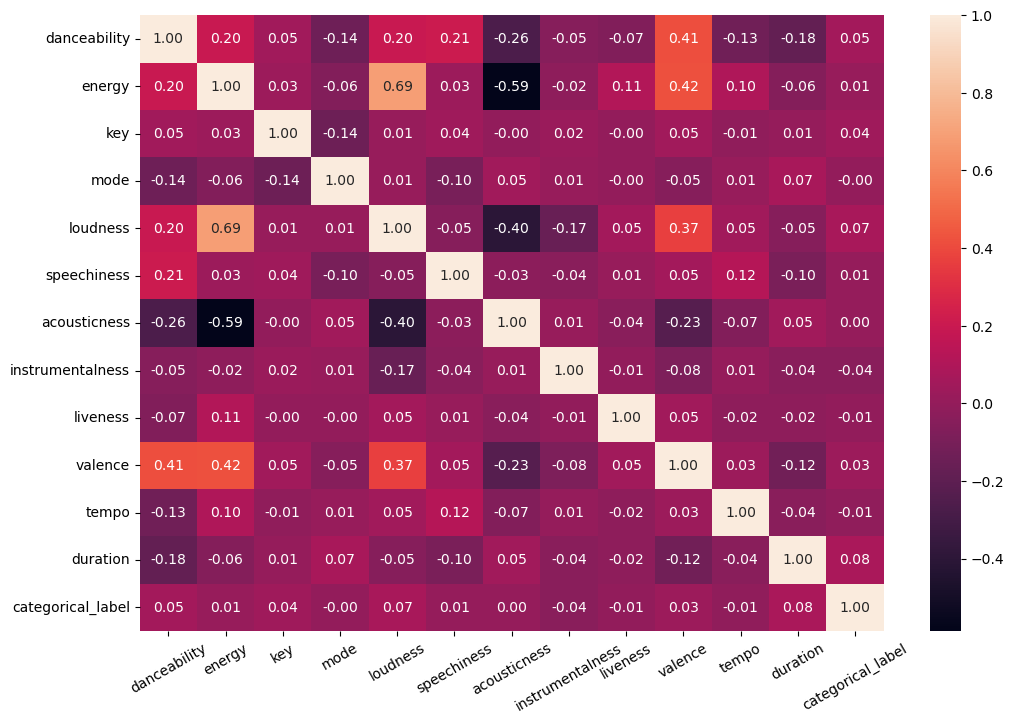

In [299]:
import matplotlib.pyplot as plt 
import seaborn as sns

audio_cols = ['danceability', 'energy', 'key', 'mode', 'loudness', 'speechiness', 
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']
plt.figure(figsize=(12,8))
sns.heatmap(df[audio_cols+['categorical_label']].corr(), annot=True, fmt='.2f')
plt.xlabel('Tương quan giữa các đặc trưng âm thanh')
plt.xticks(rotation=30)
plt.show()

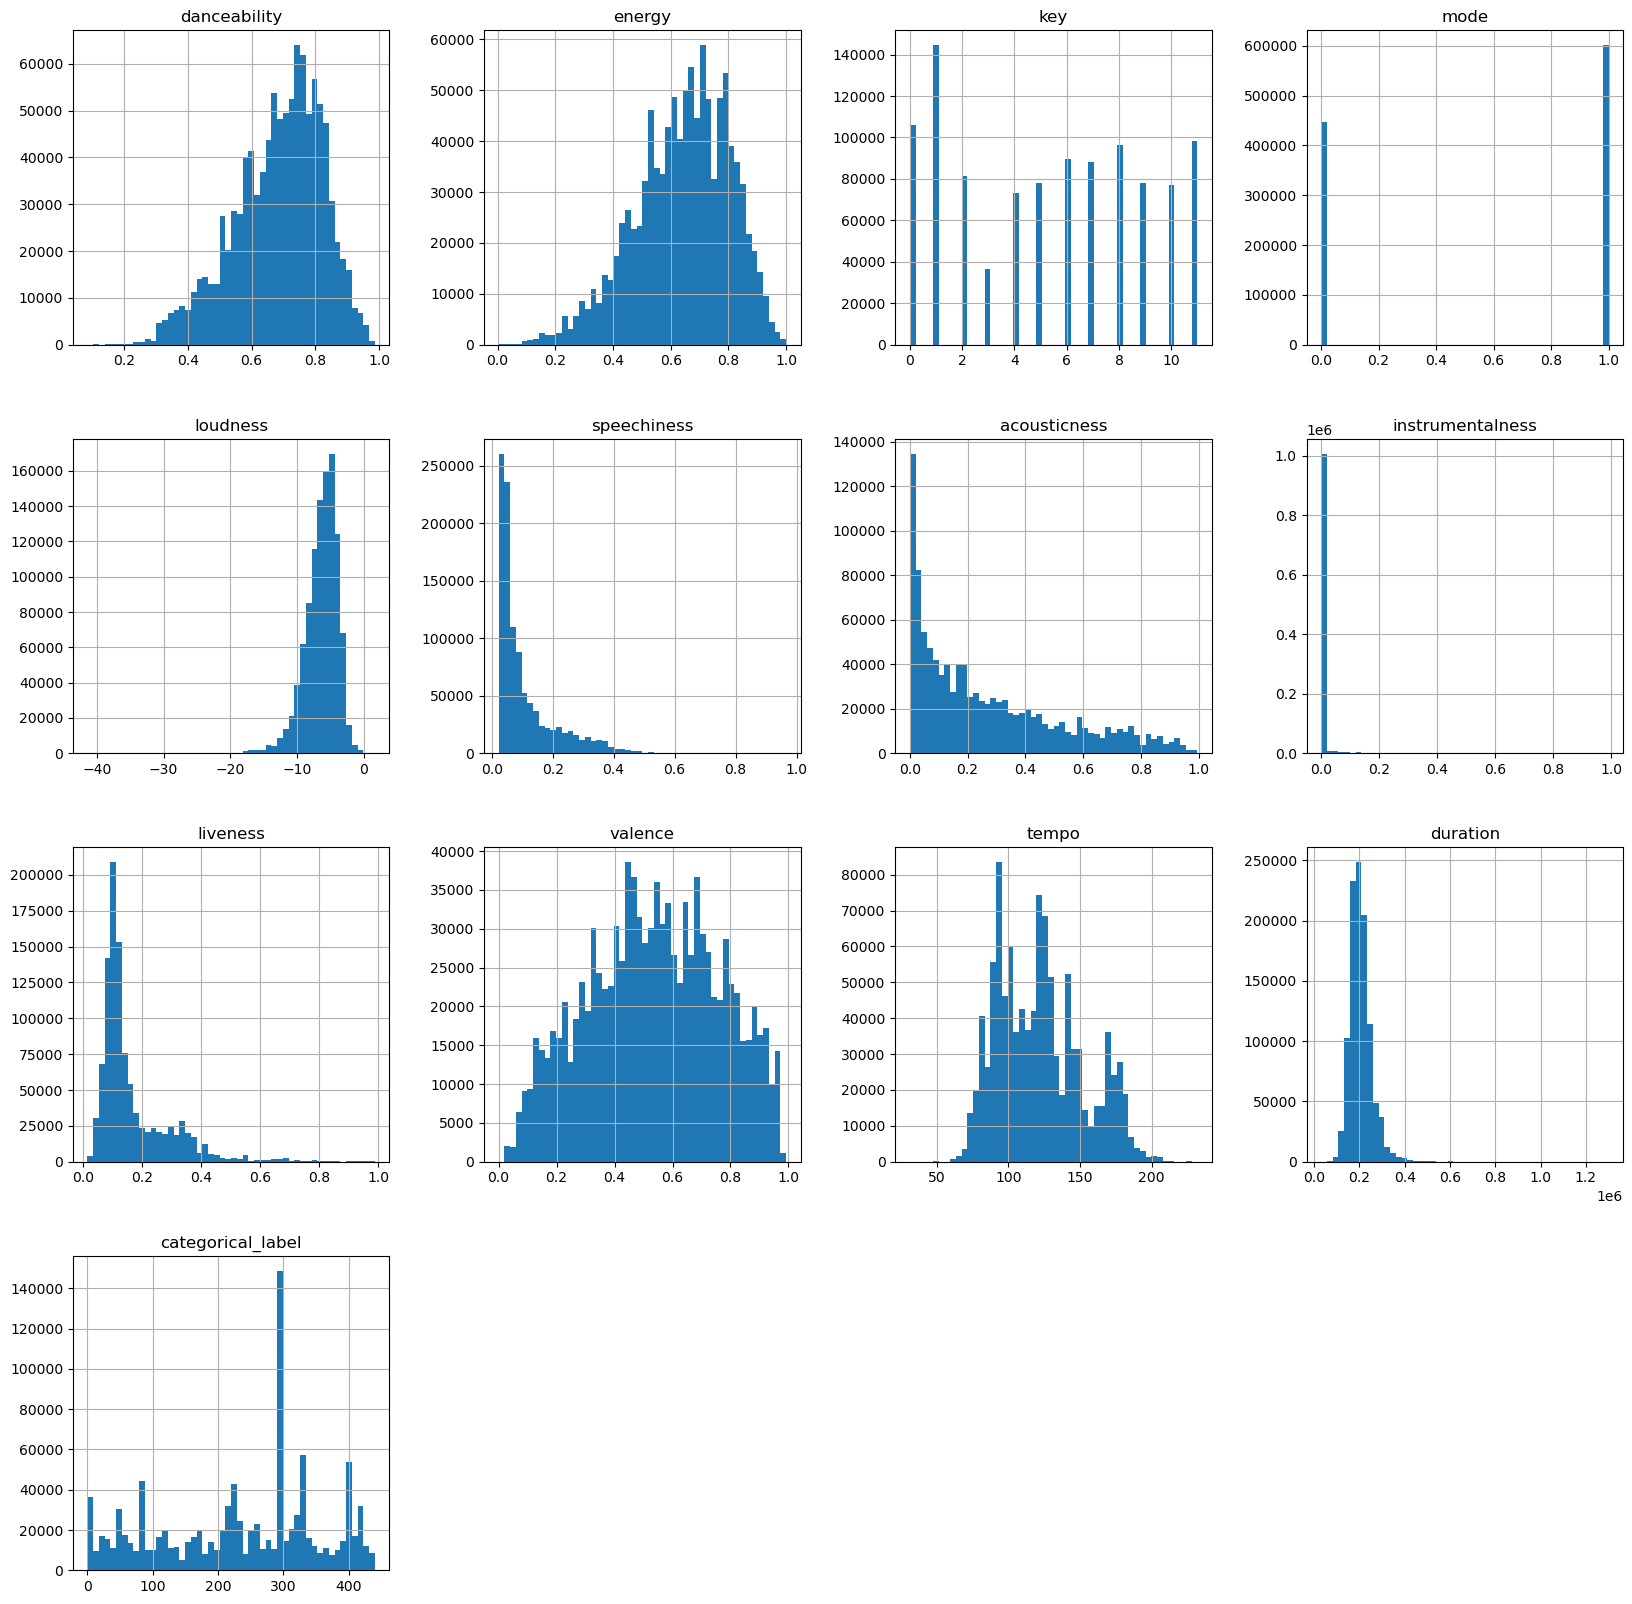

In [300]:
df[audio_cols+['categorical_label']].hist(bins=50, figsize=(20,20))
# ax.set_title("Hisogram plot", size=15, weight='bold')
plt.show()

In [301]:
imp = SimpleImputer(missing_values = np.nan, strategy = 'median') # điền các gía trị thiếu bằng median
df[audio_cols] = imp.fit_transform(df[audio_cols])
df[audio_cols].isna().sum()

danceability        0
energy              0
key                 0
mode                0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration            0
dtype: int64

In [302]:
new_df = df[audio_cols+['categorical_label']]
for i in new_df.columns:
  print(f'Skewness in {i} =',new_df[i].skew())

Skewness in danceability = -0.5660016137530796
Skewness in energy = -0.5077349038170164
Skewness in key = 0.010438139118585743
Skewness in mode = -0.2984299807338622
Skewness in loudness = -1.0533343545269203
Skewness in speechiness = 1.821096667251666
Skewness in acousticness = 0.9414640722950741
Skewness in instrumentalness = 9.194023746692181
Skewness in liveness = 2.224098231636559
Skewness in valence = -0.0821093704312116
Skewness in tempo = 0.47128186326710186
Skewness in duration = 1.6955487064390449
Skewness in categorical_label = -0.3088566854828406


skew > 0 => Lệch bên phải ( đuôi bên phải ) - Positive Skewness và ngược lại với skew < 0<br>
https://www.sharkclass.vn/glossary/do-lech-%28skewness%29?lang=en

Các cột có high skew: 
- loudness
- speechiness
- acousticness
- instrucmentalness
- liveness
- duration

In [303]:
df['loudness_trans'] = np.cbrt(df['loudness'])
df['speechiness_trans'] = np.reciprocal(df['speechiness'])
df['acousticness_trans'] = np.cbrt(df['acousticness'])
df['instrumentalness_trans'] = np.log(df['instrumentalness'].apply(lambda x: x + 0.000001))
df['liveness_trans'] = np.cbrt(df['liveness'])
df['duration_trans'] = np.sqrt(df['duration'])
df['tempo_trans'] = np.cbrt(df['tempo'])

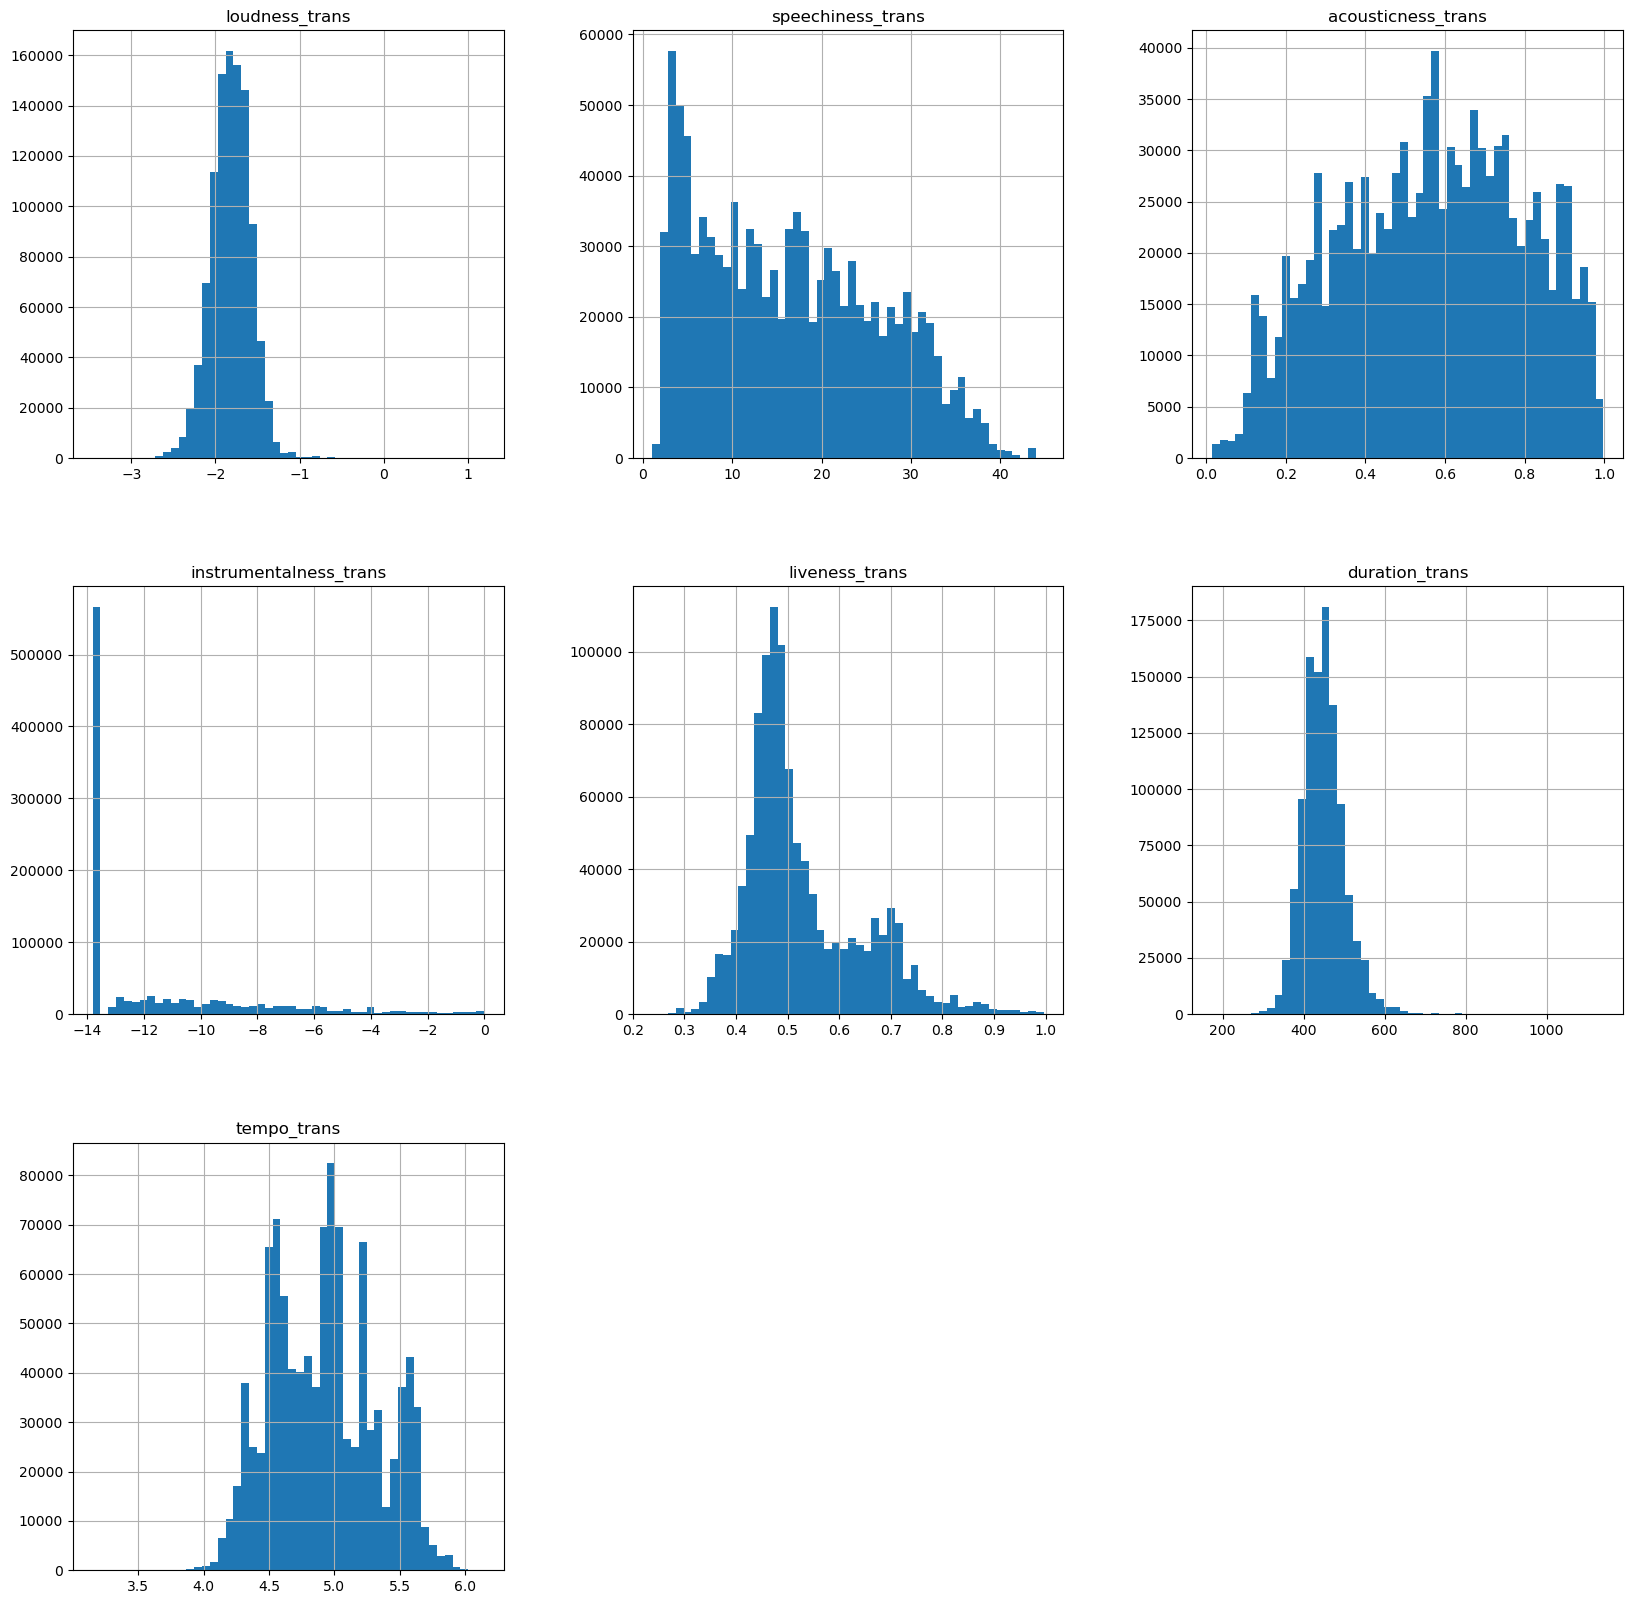

In [304]:
audio_trans  =['loudness_trans','speechiness_trans','acousticness_trans','instrumentalness_trans','liveness_trans','duration_trans','tempo_trans']
df[audio_trans].hist(bins=50, figsize=(20,20))
# ax.set_title("Hisogram plot", size=15, weight='bold')
plt.show()

In [307]:
df.drop(columns = ['duration','loudness','speechiness','acousticness','instrumentalness','liveness','tempo'], inplace = True)

#### **Mô hình hoá dữ liệu**

In [308]:
columns = ["artist_names","track_name"]
le = LabelEncoder()
for col in columns:
  df[col] = le.fit_transform(df[col])

In [309]:
X = df[['danceability', 'energy', 'key',
       'mode', 'valence', 
       'duration_trans','loudness_trans',
        'speechiness_trans','acousticness_trans','instrumentalness_trans','liveness_trans','tempo_trans']]
Y = df['categorical_label']

**Chia tập train/test**

In [310]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=11)

**XG Boost sử dụng Standard Scaler**

In [312]:
scaler = StandardScaler()
normalized_x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)

Xgbclassifier = xgb.XGBClassifier(max_depth=5, objective='multi:softprob', n_estimators=1000, 
                        num_classes=21, random_state=5).fit(normalized_x_train, y_train)

normalized_x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)
y_pred = Xgbclassifier.predict(normalized_x_test)

XGBAcc = accuracy_score(y_pred,y_test)
print('XG Boost accuracy is: {:.2f}%'.format(XGBAcc*100))

[10:46:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_classes" } are not used.



KeyboardInterrupt: 

In [ ]:
Xgbclassifier.save_model('xgb_model.json')

**XBBoost sử dụng Normalizer**

In [ ]:
normalizer = Normalizer()
normalized_x_train = pd.DataFrame(normalizer.fit_transform(x_train), columns = x_train.columns)

Xgbclassifier = xgb.XGBClassifier(max_depth=5, objective='multi:softprob', n_estimators=1000, 
                        num_classes=14, random_state=5).fit(normalized_x_train, y_train)

normalized_x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)
y_pred = Xgbclassifier.predict(normalized_x_test)

XGBAcc = accuracy_score(y_pred,y_test)
print('XG Boost accuracy is: {:.2f}%'.format(XGBAcc*100))

[00:48:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_classes" } are not used.

XG Boost accuracy is: 13.10%


**Logistic Regression sử dụng MinMaxScaler**

In [ ]:
scaler = MinMaxScaler()

normalized_x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)

LR = LogisticRegression(solver='newton-cg', multi_class = 'multinomial',random_state = 7).fit(normalized_x_train, y_train)

normalized_x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)
y_pred = LR.predict(normalized_x_test)

LRAcc = accuracy_score(y_pred,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LRAcc*100))

Logistic Regression accuracy is: 18.19%


**Random Forest**

In [ ]:

scaler = StandardScaler()

normalized_x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)

RFclassifier = RandomForestClassifier(max_leaf_nodes = 30,random_state = 3).fit(normalized_x_train, y_train)

normalized_x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)
y_pred = RFclassifier.predict(normalized_x_test)

from sklearn.metrics import accuracy_score
RFAcc = accuracy_score(y_pred,y_test)
print('Random Forest accuracy is: {:.2f}%'.format(RFAcc*100))

Random Forest accuracy is: 19.31%


***

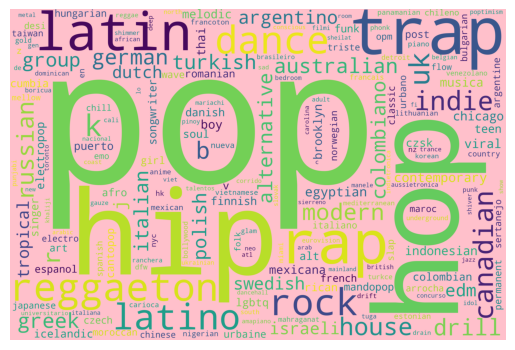

In [ ]:
text = ', '.join(spotify_df['artist_genre'])
word_cloud = WordCloud(width=3000, 
                       height=2000, 
                       random_state=1, 
                     #  background_color='pink', 
                     #   colormap='Pastel1',
                       collocations=False,
                       stopwords=', ').generate(text)

plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
# def reduce_categories(col, threshold=0.85):
#     threshold_value = int(threshold*len(col))
#     reduced_cats = []
#     s = 0
#     counts = Counter(col)
    
#     for i, j in counts.most_common():
#         s+=dict(counts)[i]
#         reduced_cats.append(i)
#         if s>=threshold_value:
#             break
#     reduced_cats.append('Other')
    
#     new_col=col.apply(lambda x: x if x in reduced_cats else 'Other')
#     return new_col, reduced_cats

# col, cate = reduce_categories(spotify_df['artist_genre'])
# col.value_counts()

Other                             166242
pop                               125702
trap latino                       42656 
latin                             38454 
reggaeton                         36275 
dance pop                         34766 
0                                 28796 
uk pop                            19249 
rap                               18180 
k-pop                             16274 
canadian pop                      14710 
reggaeton colombiano              10558 
latin pop                         9878  
hip hop                           9511  
australian hip hop                8790  
pop dance                         8365  
modern rock                       8173  
pop rap                           7898  
german hip hop                    7731  
edm                               7309  
russian hip hop                   7060  
tropical house                    7029  
rock                              6957  
k-pop boy group                   6741  
brooklyn drill  

### **Trả lời câu hỏi 2**: Thời gian nào trong năm thì bài hát dễ 'lên hạng'?

In [ ]:
spotify_df.sample(5)

,uri,rank,artist_names,artists_num,artist_individual,artist_id,artist_genre,artist_img,track_name,release_date,album_num_tracks,album_cover,source,peak_rank,previous_rank,weeks_on_chart,streams,week,danceability,energy,key,mode,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,country,region,language,pivot
519932,spotify:track:7IPKXYU2rTMnrLW5IZ7ZI5,66,Dave,1,Dave,spotify:artist:6Ip8FS7vWT1uKkJSweANQK,uk hip hop,https://i.scdn.co/image/ab6761610000e5eb76d47d16d18eb30413469512,Verdansk,2021-07-22,12.0,https://i.scdn.co/image/ab67616d0000b273da5b9c1eb275d48e14d25f3e,Neighbourhood,9,51,5,67367,2021-08-26,0.961,0.502,2.0,1.0,-8.605,0.3120,0.2800,0.000000,0.145,0.536,117.078,182285.0,Ireland,Europe,English,0
196091,spotify:track:6ZuahEctZD6w75peme58hm,48,Shawn Mendes,1,Shawn Mendes,spotify:artist:7n2wHs1TKAczGzO7Dd2rGr,canadian pop,https://i.scdn.co/image/ab6761610000e5eb46e7a06fa6dfefaed6a3f0db,Wonder,2020-12-04,14.0,https://i.scdn.co/image/ab67616d0000b27337a5a19e52f8260b3b158e55,Shawn Mendes LP4-5 PS/ Island,20,49,18,51009,2021-02-04,0.442,0.631,1.0,0.0,-5.096,0.0500,0.1360,0.000023,0.133,0.129,139.774,172693.0,Czech Republic,Europe,Czech,0
996581,spotify:track:5xrtzzzikpG3BLbo4q1Yul,126,IU,1,IU,spotify:artist:3HqSLMAZ3g3d5poNaI7GOU,k-pop,https://i.scdn.co/image/ab6761610000e5eb006ff3c0136a71bfb9928d34,LILAC,2021-03-25,10.0,https://i.scdn.co/image/ab67616d0000b2734ed058b71650a6ca2c04adff,EDAM Entertainment,15,120,8,53566,2021-05-20,0.738,0.890,2.0,0.0,-2.275,0.0748,0.0895,0.000002,0.213,0.750,114.942,214253.0,Thailand,Asia,Thai,0
174922,spotify:track:1riBwVUqVsk5RGJ9iLN8cG,13,Ezhel,1,Ezhel,spotify:artist:6LnJKrtFnTEGdbWQ2riWCL,turkish hip hop,https://i.scdn.co/image/ab6761610000e5eb107a201f2039a163564972cf,Bul Beni,2021-07-01,1.0,https://i.scdn.co/image/ab67616d0000b273dcef82b22983d040a659a9a0,StageArt Europe,13,14,3,10576,2021-07-22,0.797,0.540,6.0,0.0,-7.862,0.2680,0.5280,0.000000,0.102,0.348,104.001,154173.0,Cyprus,Europe,Greek,0
1053021,spotify:track:2WoksKIDPQ8o90cqDbgE7L,76,Patsyki Z Franeka,1,Patsyki Z Franeka,spotify:artist:0fB3vIwNC9q3MCIBugQ5o9,ukrainian pop,https://i.scdn.co/image/ab6761610000e5eb38ddf98cacebfdd207b60fb0,Марічка,2019-05-16,1.0,https://i.scdn.co/image/ab67616d0000b2732a820743e498da94bb2f0aa7,FFK REKORDZ,67,67,3,35906,2022-06-02,0.713,0.639,10.0,0.0,-7.509,0.0361,0.0960,0.000015,0.121,0.466,91.969,206087.0,Ukraine,Europe,Ukrainian,0


In [ ]:
standard_prev_rank = spotify_df['previous_rank'].apply(lambda x: 200 if x == -1 else x)
spotify_df['rank_up'] = standard_prev_rank - spotify_df['rank']

In [ ]:
spotify_df[spotify_df['country']=='Vietnam'][spotify_df['rank']==1]#.value_counts()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15860\3235955672.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spotify_df[spotify_df['country']=='Vietnam'][spotify_df['rank']==1]#.value_counts()


,uri,rank,artist_names,artists_num,artist_individual,artist_id,artist_genre,artist_img,track_name,release_date,album_num_tracks,album_cover,source,peak_rank,previous_rank,weeks_on_chart,streams,week,danceability,energy,key,mode,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,country,region,language,pivot,rank_up
1094320,spotify:track:186NCtNk1tUYS7c2DxgJ7O,1,V,1,V,spotify:artist:3JsHnjpbhX4SnySpvpa9DK,korean ost,https://i.scdn.co/image/ab6761610000e5ebfe5cecc2ed191d2db9acdc90,Christmas Tree,2021-12-24,2.0,https://i.scdn.co/image/ab67616d0000b2738764ebc69bd91a01cc3948a2,MOST CONTENTS,1,-1,1,562360,2021-12-30,0.437,0.384,5.0,1.0,-8.384,0.0420,0.69900,0.000023,0.1210,0.181,139.009,209947.0,Vietnam,Asia,Vietnamese,0,199
1094429,spotify:track:0gplL1WMoJ6iYaPgMCL0gX,1,Adele,1,Adele,spotify:artist:4dpARuHxo51G3z768sgnrY,pop,https://i.scdn.co/image/ab6761610000e5eb68f6e5892075d7f22615bd17,Easy On Me,2021-10-14,1.0,https://i.scdn.co/image/ab67616d0000b27350dba34377a595e35f81b0e4,Columbia,1,-1,1,473784,2021-10-21,0.604,0.366,5.0,1.0,-7.519,0.0282,0.57800,0.000000,0.1330,0.130,141.981,224695.0,Vietnam,Asia,Vietnamese,0,199
1094551,spotify:track:7uQZVznj0uQOGC9KhV2Mg6,1,LISA,1,LISA,spotify:artist:5L1lO4eRHmJ7a0Q6csE5cT,k-pop,https://i.scdn.co/image/ab6761610000e5eb7315c4978296c4de311f577e,LALISA,2021-09-10,2.0,https://i.scdn.co/image/ab67616d0000b273330f11fb125bb80b760f9e19,YG Entertainment/Interscope Records,1,-1,1,506931,2021-09-16,0.806,0.653,8.0,1.0,-6.283,0.0902,0.02820,0.000784,0.1070,0.850,150.058,200690.0,Vietnam,Asia,Vietnamese,0,199
1094925,spotify:track:7CAdT0HdiQNlt1C7xk2hep,1,Jung Kook,1,Jung Kook,spotify:artist:6HaGTQPmzraVmaVxvz6EUc,0,https://i.scdn.co/image/ab6761610000e5eb219729769002abab3f23ef21,Stay Alive (Prod. SUGA of BTS),2022-02-11,1.0,https://i.scdn.co/image/ab67616d0000b2738916a2bb404bed6755f2bbbd,BIGHIT MUSIC,1,-1,1,1586444,2022-02-17,0.512,0.760,2.0,0.0,-5.889,0.0682,0.29900,0.000000,0.1030,0.495,130.096,210928.0,Vietnam,Asia,Vietnamese,0,199
1095158,spotify:track:5fFLotKS1286huYIMQHqz7,1,Sơn Tùng M-TP,1,Sơn Tùng M-TP,spotify:artist:5dfZ5uSmzR7VQK0udbAVpf,vietnamese melodic rap,https://i.scdn.co/image/ab6761610000e5eb1036554ddc5f791a4f5dcfc3,Muộn Rồi Mà Sao Còn,2021-04-29,1.0,https://i.scdn.co/image/ab67616d0000b27329f906fe7a60df7777b02ee1,M-TP Entertainment Ltd,1,91,2,1208277,2021-05-06,0.888,0.418,0.0,1.0,-9.812,0.0573,0.66500,0.000000,0.1110,0.531,127.073,275906.0,Vietnam,Asia,Vietnamese,0,90
1095288,spotify:track:5fFLotKS1286huYIMQHqz7,1,Sơn Tùng M-TP,1,Sơn Tùng M-TP,spotify:artist:5dfZ5uSmzR7VQK0udbAVpf,v-pop,https://i.scdn.co/image/ab6761610000e5eb1036554ddc5f791a4f5dcfc3,Muộn Rồi Mà Sao Còn,2021-04-29,1.0,https://i.scdn.co/image/ab67616d0000b27329f906fe7a60df7777b02ee1,M-TP Entertainment Ltd,1,1,3,828498,2021-05-13,0.888,0.418,0.0,1.0,-9.812,0.0573,0.66500,0.000000,0.1110,0.531,127.073,275906.0,Vietnam,Asia,Vietnamese,0,0
1095420,spotify:track:6GJi4nSZOiTOU2FhsgxWyH,1,Vũ.,1,Vũ.,spotify:artist:57g2v7gJZepcwsuwssIfZs,indie viet,https://i.scdn.co/image/ab6761610000e5ebec1bd421630bf3ad110c09fa,Bước Qua Nhau,2021-11-11,2.0,https://i.scdn.co/image/ab67616d0000b2734eca4595da187b3a25eb9958,WM Vietnam,1,4,6,244320,2021-12-23,0.541,0.339,1.0,1.0,-6.499,0.0268,0.74200,0.000109,0.1860,0.215,135.757,257647.0,Vietnam,Asia,Vietnamese,0,3
1095533,spotify:track:6GJi4nSZOiTOU2FhsgxWyH,1,Vũ.,1,Vũ.,spotify:artist:57g2v7gJZepcwsuwssIfZs,v-pop,https://i.scdn.co/image/ab6761610000e5ebec1bd421630bf3ad110c09fa,Bước Qua Nhau,2021-11-11,2.0,https://i.scdn.co/image/ab67616d0000b2734eca4595da187b3a25eb9958,WM Vietnam,1,1,4,358182,2021-12-09,0.541,0.339,1.0,1.0,-6.499,0.0268,0.74200,0.000109,0.1860,0.215,135.757,257647.0,Vietnam,Asia,Vietnamese,0,0
1095648,spotify:track:2jk6oBuLiCZJTDWhlJEzIw,1,j-hope,1,j-hope,spotify:artist:0b1sIQumIAsNbqAoIClSpy,k-rap,https://i.scdn.co/image/ab6761610000e5ebfa980b99bc5f4d47b4253f82,Airplane,2018-03-02,7.0,https://i.scdn.co/image/ab67616d0000b273a2de0bc4a200af9490ca

In [ ]:
trending = spotify_df[spotify_df['country']=='Vietnam'][spotify_df['rank_up']==spotify_df['rank_up'].max()]
trending

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15860\4125805770.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trending = spotify_df[spotify_df['country']=='Vietnam'][spotify_df['rank_up']==spotify_df['rank_up'].max()]


,uri,rank,artist_names,artists_num,artist_individual,artist_id,artist_genre,artist_img,track_name,release_date,album_num_tracks,album_cover,source,peak_rank,previous_rank,weeks_on_chart,streams,week,danceability,energy,key,mode,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,country,region,language,pivot,rank_up
1094320,spotify:track:186NCtNk1tUYS7c2DxgJ7O,1,V,1,V,spotify:artist:3JsHnjpbhX4SnySpvpa9DK,korean ost,https://i.scdn.co/image/ab6761610000e5ebfe5cecc2ed191d2db9acdc90,Christmas Tree,2021-12-24,2.0,https://i.scdn.co/image/ab67616d0000b2738764ebc69bd91a01cc3948a2,MOST CONTENTS,1,-1,1,562360,2021-12-30,0.437,0.384,5.0,1.0,-8.384,0.0420,0.69900,0.000023,0.1210,0.181,139.009,209947.0,Vietnam,Asia,Vietnamese,0,199
1094429,spotify:track:0gplL1WMoJ6iYaPgMCL0gX,1,Adele,1,Adele,spotify:artist:4dpARuHxo51G3z768sgnrY,pop,https://i.scdn.co/image/ab6761610000e5eb68f6e5892075d7f22615bd17,Easy On Me,2021-10-14,1.0,https://i.scdn.co/image/ab67616d0000b27350dba34377a595e35f81b0e4,Columbia,1,-1,1,473784,2021-10-21,0.604,0.366,5.0,1.0,-7.519,0.0282,0.57800,0.000000,0.1330,0.130,141.981,224695.0,Vietnam,Asia,Vietnamese,0,199
1094551,spotify:track:7uQZVznj0uQOGC9KhV2Mg6,1,LISA,1,LISA,spotify:artist:5L1lO4eRHmJ7a0Q6csE5cT,k-pop,https://i.scdn.co/image/ab6761610000e5eb7315c4978296c4de311f577e,LALISA,2021-09-10,2.0,https://i.scdn.co/image/ab67616d0000b273330f11fb125bb80b760f9e19,YG Entertainment/Interscope Records,1,-1,1,506931,2021-09-16,0.806,0.653,8.0,1.0,-6.283,0.0902,0.02820,0.000784,0.1070,0.850,150.058,200690.0,Vietnam,Asia,Vietnamese,0,199
1094925,spotify:track:7CAdT0HdiQNlt1C7xk2hep,1,Jung Kook,1,Jung Kook,spotify:artist:6HaGTQPmzraVmaVxvz6EUc,0,https://i.scdn.co/image/ab6761610000e5eb219729769002abab3f23ef21,Stay Alive (Prod. SUGA of BTS),2022-02-11,1.0,https://i.scdn.co/image/ab67616d0000b2738916a2bb404bed6755f2bbbd,BIGHIT MUSIC,1,-1,1,1586444,2022-02-17,0.512,0.760,2.0,0.0,-5.889,0.0682,0.29900,0.000000,0.1030,0.495,130.096,210928.0,Vietnam,Asia,Vietnamese,0,199
1095648,spotify:track:2jk6oBuLiCZJTDWhlJEzIw,1,j-hope,1,j-hope,spotify:artist:0b1sIQumIAsNbqAoIClSpy,k-rap,https://i.scdn.co/image/ab6761610000e5ebfa980b99bc5f4d47b4253f82,Airplane,2018-03-02,7.0,https://i.scdn.co/image/ab67616d0000b273a2de0bc4a200af9490caa662,BIGHIT MUSIC,1,-1,1,454813,2022-02-10,0.801,0.651,0.0,1.0,-7.855,0.0579,0.65000,0.000000,0.1090,0.238,119.992,197914.0,Vietnam,Asia,Vietnamese,0,199
1096139,spotify:track:0LThjFY2iTtNdd4wviwVV2,1,BTS,1,BTS,spotify:artist:3Nrfpe0tUJi4K4DXYWgMUX,k-pop,https://i.scdn.co/image/ab6761610000e5eb5704a64f34fe29ff73ab56bb,Permission to Dance,2021-07-09,4.0,https://i.scdn.co/image/ab67616d0000b2739c194644c08101a2b44d1b31,BIGHIT MUSIC,1,-1,1,505613,2021-07-15,0.702,0.741,9.0,1.0,-5.330,0.0427,0.00544,0.000000,0.3370,0.646,124.925,187585.0,Vietnam,Asia,Vietnamese,0,199
1098505,spotify:track:10SRMwb9EuVS1K9rYsBfHQ,1,BTS,1,BTS,spotify:artist:3Nrfpe0tUJi4K4DXYWgMUX,k-pop boy group,https://i.scdn.co/image/ab6761610000e5eb5704a64f34fe29ff73ab56bb,Yet To Come,2022-06-10,35.0,https://i.scdn.co/image/ab67616d0000b27317db30ce3f081d6818a8ad49,BIGHIT MUSIC,1,-1,1,1755027,2022-06-16,0.559,0.885,1.0,1.0,-4.515,0.1890,0.04320,0.000000,0.3330,0.683,172.029,193594.0,Vietnam,Asia,Vietnamese,0,199
1098964,spotify:track:1Y7AZ3akqDipAyo6mmOQTy,1,Agust D,1,Agust D,spotify:artist:5RmQ8k4l3HZ8JoPb4mNsML,k-rap,https://i.scdn.co/image/ab6761610000e5ebe94c521bbe0604a5fcd4f8bf,Daechwita,2020-05-22,10.0,https://i.scdn.co/image/ab67616d0000b2736c0e2c778e672701e1a254c6,BIGHIT MUSIC,1,-1,11,396761,2022-03-03,0.650,0.827,8.0,1.0,-4.014,0.0599,0.02290,0.000000,0.1210,0.223,144.995,225668.0,Vietnam,Asia,Vietnamese,0,199
1100324,spotify:track:2pn8dNVSpYnAtlKFC8Q0DJ,1,ROSÉ,1,ROSÉ,spotify:artist:3eVa5w3URK5duf6eyVDbu9,k-pop,https://i.scdn.co/image/ab6761610000e5eba23b22965ecef5703f58b6c5,On The Ground,2021-03-12,2.0,https://i.scdn.co/image/ab67616d0000b273fdec91537c467efa0cd75e2f,YG Entertainment/Interscope Records,1,-1,1,595967,20

In [ ]:
x = spotify_df[spotify_df['country']=='Vietnam'].groupby(spotify_df['week'].dt.month)['rank_up'].value_counts()
display(x)

week  rank_up
1     -1         40
       0         39
      -2         38
      -6         34
       2         33
                 ..
12     173       1 
       179       1 
       180       1 
       187       1 
       197       1 
Name: rank_up, Length: 1862, dtype: int64

In [ ]:
pd.DataFrame(x.to_frame().rename(columns={'rank_up': 'counts'}).reset_index().sort_values(by=['rank_up']))

,week,rank_up,counts
566,4,-166,1
1791,12,-151,1
402,3,-140,1
1792,12,-136,1
955,6,-133,1
...,...,...,...
826,5,199,1
1790,12,199,2
954,6,199,2
1707,11,199,1


Check một bài hát đã ở trong top tuần này có ở trong top tuần khác không?

In [ ]:
spotify_df[spotify_df['country'] == 'Global']

,uri,rank,artist_names,artists_num,artist_individual,artist_id,artist_genre,artist_img,track_name,release_date,album_num_tracks,album_cover,source,peak_rank,previous_rank,weeks_on_chart,streams,week,danceability,energy,key,mode,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,country,region,language,pivot,rank_up
338782,spotify:track:6MWtB6iiXyIwun0YzU6DFP,2,Post Malone,1,Post Malone,spotify:artist:246dkjvS1zLTtiykXe5h60,rap,https://i.scdn.co/image/ab6761610000e5ebb894ef9fa437b0389c5567cc,Wow.,2018-12-24,1.0,https://i.scdn.co/image/ab67616d0000b27379eb2363cc79781b03d80b2e,Republic Records,2,3,4,29944242,2019-01-17,0.833,0.539,11.0,0.0,-7.399,0.1780,0.1630,0.000002,0.1010,0.385,99.947,149520.0,Global,Global,Global,0,1
338783,spotify:track:2rPE9A1vEgShuZxxzR2tZH,3,Ariana Grande,1,Ariana Grande,spotify:artist:66CXWjxzNUsdJxJ2JdwvnR,pop,https://i.scdn.co/image/ab6761610000e5ebcdce7620dc940db079bf4952,"thank u, next",2018-11-03,1.0,https://i.scdn.co/image/ab67616d0000b273ffa275ba245edba4c1c720af,Republic Records,1,2,11,27807232,2019-01-17,0.724,0.647,1.0,1.0,-5.642,0.0658,0.2800,0.000000,0.1020,0.435,106.960,207333.0,Global,Global,Global,0,-1
338784,spotify:track:5p7ujcrUXASCNwRaWNHR1C,4,Halsey,1,Halsey,spotify:artist:26VFTg2z8YR0cCuwLzESi2,electropop,https://i.scdn.co/image/ab6761610000e5ebd707e1c5177614c4ec95a06c,Without Me,2018-10-04,1.0,https://i.scdn.co/image/ab67616d0000b273c42acc1b86597285c2c79559,Capitol Records,4,4,15,27138512,2019-01-17,0.752,0.488,6.0,1.0,-7.050,0.0705,0.2970,0.000009,0.0936,0.533,136.041,201661.0,Global,Global,Global,0,0
338785,spotify:track:25sgk305KZfyuqVBQIahim,6,Ava Max,1,Ava Max,spotify:artist:4npEfmQ6YuiwW1GpUmaq3F,pop,https://i.scdn.co/image/ab6761610000e5eb27a772a3d3f62f6fc990ce0f,Sweet but Psycho,2018-08-17,1.0,https://i.scdn.co/image/ab67616d0000b273c5015d2a9270865a5979f56b,Atlantic Records,6,6,16,22400542,2019-01-17,0.719,0.704,1.0,1.0,-4.724,0.0476,0.0691,0.000000,0.1660,0.628,133.002,187436.0,Global,Global,Global,0,0
338786,spotify:track:1rqqCSm0Qe4I9rUvWncaom,9,Panic! At The Disco,1,Panic! At The Disco,spotify:artist:20JZFwl6HVl6yg8a4H3ZqK,modern rock,https://i.scdn.co/image/ab6761610000e5ebb256ae9a4b82bfff97776ae2,High Hopes,2018-06-22,11.0,https://i.scdn.co/image/ab67616d0000b273c5148520a59be191eea16989,DCD2 / Fueled By Ramen,9,11,30,19643546,2019-01-17,0.579,0.904,5.0,1.0,-2.729,0.0618,0.1930,0.000000,0.0640,0.681,82.014,190947.0,Global,Global,Global,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396770,spotify:track:6WkJ2OK163XXS2oARUC9JM,188,"Aaron Smith, Krono, Luvli",3,Aaron Smith,spotify:artist:77qukKzmdI5BeMBR7WGUrN,chicago house,https://i.scdn.co/image/ab6761610000e5eb4e3b9e4559d3cff50dcc69cf,Dancin (feat. Luvli) - Krono Remix,2014-11-07,1.0,https://i.scdn.co/image/ab67616d0000b273f7a3a5656060030a0d24855c,Sony Music Entertainment,101,167,15,4606395,2019-06-13,0.720,0.741,10.0,0.0,-6.529,0.0287,0.1010,0.000014,0.2890,0.357,119.896,198053.0,Global,Global,Global,0,-21
396771,spotify:track:2kkcJ8tSDV42LdWcPjy6We,194,"Samra, Capital Bra",2,Samra,spotify:artist:6h1s4i4XKIYv4ErDelLDN0,german hip hop,https://i.scdn.co/image/ab6761610000e5eb434a7526f8a622e4b3c3bb79,Wieder Lila,2019-05-17,1.0,https://i.scdn.co/image/ab67616d0000b273beb0cccc098b713f30c4ed43,Urban,47,132,4,4547192,2019-06-13,0.656,0.756,2.0,0.0,-4.026,0.3000,0.4350,0.000000,0.0934,0.645,168.031,188057.0,Global,Global,Global,0,-62
396772,spotify:track:2tOOcDDYkh0PSjr6GwPEAJ,196,"MAX, Quinn XCII",2,MAX,spotify:artist:1bqxdqvUtPWZri43cKHac8,electropop,https://i.scdn.co/image/ab6761610000e5eb09ce0644c08fa03347ef8928,Love Me Less (feat. Quinn XCII),2019-04-05,1.0,https://i.scdn.co/image/ab67616d0000b273038e01a9fbf375dcccea5a3c,Colour Vision Records/Sony Music Entertainment,135,168,4,4538692,2019-06-13,0.732,0.856,11.0,0.0,-2.200,0.0929,0.0828,0.000000,0.3230,0.771,145.034,177670.0,Global,Global,Gl

In [ ]:
spotify_df.groupby('week')['track_name'].value_counts().to_frame()

track_name
week       track_name                                          
2016-12-29 All I Want for Christmas Is You           2         
           24K Magic                                 1         
           7 Years                                   1         
           A Holly Jolly Christmas - Single Version  1         
           Ain't My Fault                            1         
...                                                 ..         
2022-07-14 高嶺の花子さん                                   1         
           鯨落                                        1         
           黑暗的盡頭                                     1         
           니가 왜 거기서 나와 (Narr. 고은아)                   1         
           스물다섯, 스물하나                                1         

[452810 rows x 1 columns]

---

### **Câu hỏi 3**: Ca khúc nào có được nhiều sự yêu thích ở các Quốc gia ?

Ca khúc được yêu thích dựa trên các yếu tố như: <br>
+ Được lên top 10 Quốc gia.
+ Có được thời gian trong top lâu nhất liên tục qua các quá trình cập nhật.

Đầu tiên xét ở một quốc gia nhỏ như Việt Nam trước khi đến toàn bộ Quốc gia của dataset đề cập.

Kiểm tra lại các cột trước khi tiến hành trả lời câu hỏi.

In [ ]:
spotify_df.columns

Index(['uri', 'rank', 'artist_names', 'artists_num', 'artist_individual',
       'artist_id', 'artist_genre', 'artist_img', 'track_name', 'release_date',
       'album_num_tracks', 'album_cover', 'source', 'peak_rank',
       'previous_rank', 'weeks_on_chart', 'streams', 'week', 'danceability',
       'energy', 'key', 'mode', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration',
       'country', 'region', 'language', 'pivot'],
      dtype='object')

In [ ]:
cols = ["uri", "artist_names", "track_name", "week", "streams", "country"]
spotify_df[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109520 entries, 0 to 1109519
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   uri           1109520 non-null  object
 1   artist_names  1109520 non-null  object
 2   track_name    1109520 non-null  object
 3   week          1109520 non-null  object
 4   streams       1109520 non-null  int64 
 5   country       1109520 non-null  object
dtypes: int64(1), object(5)
memory usage: 50.8+ MB


Không có dòng thiếu. Tiến hành trả lời câu hỏi.


**Bước 1**: Chọn các bài hát thuộc Quốc gia Việt Nam

In [ ]:
def song_in_country(country):
    return spotify_df[spotify_df.country == country]

In [ ]:
song_in_vietnam_df = song_in_country("Vietnam")

**Bước 2**: Chọn các bài hát được đưa lên top 1 Việt Nam

In [ ]:
def song_in_top_10(df):
    return df[df["rank"] <= 10]

In [ ]:
top10_df = song_in_top_10(song_in_vietnam_df)

**Bước 3**: Tạo một mảng đánh dấu lại các ngày được lên top10

In [ ]:
group_weeks = top10_df.groupby("uri")["week"].apply(lambda grp: list(set(grp))).reset_index()

In [ ]:
weeks = sorted(top10_df.week.unique())
weeks

['2021-02-04',
 '2021-02-11',
 '2021-02-18',
 '2021-02-25',
 '2021-03-04',
 '2021-03-11',
 '2021-03-18',
 '2021-03-25',
 '2021-04-01',
 '2021-04-08',
 '2021-04-15',
 '2021-04-22',
 '2021-04-29',
 '2021-05-06',
 '2021-05-13',
 '2021-05-20',
 '2021-05-27',
 '2021-06-03',
 '2021-06-10',
 '2021-06-17',
 '2021-06-24',
 '2021-07-01',
 '2021-07-08',
 '2021-07-15',
 '2021-07-22',
 '2021-07-29',
 '2021-08-05',
 '2021-08-12',
 '2021-08-19',
 '2021-08-26',
 '2021-09-02',
 '2021-09-09',
 '2021-09-16',
 '2021-09-23',
 '2021-09-30',
 '2021-10-07',
 '2021-10-14',
 '2021-10-21',
 '2021-10-28',
 '2021-11-04',
 '2021-11-11',
 '2021-11-18',
 '2021-11-25',
 '2021-12-02',
 '2021-12-09',
 '2021-12-16',
 '2021-12-23',
 '2021-12-30',
 '2022-01-06',
 '2022-01-13',
 '2022-01-20',
 '2022-01-27',
 '2022-02-03',
 '2022-02-10',
 '2022-02-17',
 '2022-02-24',
 '2022-03-03',
 '2022-03-10',
 '2022-03-17',
 '2022-03-24',
 '2022-03-31',
 '2022-04-07',
 '2022-04-14',
 '2022-04-21',
 '2022-04-28',
 '2022-05-05',
 '2022-05-

In [ ]:
def check_week_series(aWeeks):
    aDates = np.zeros(len(weeks))
    lIndex = [weeks.index(week) for week in aWeeks] # get index from "weeks"
    aDates[lIndex] = 1
    return aDates

In [ ]:
# group_weeks["check_date"] = group_weeks.apply(lambda x: check_date_series(x.week), axis =1)
group_weeks["check_week"] = group_weeks.week.apply(check_week_series)
group_weeks

,uri,week,check_week
0,spotify:track:014DA3BdnmD3kI5pBogH7c,[2021-04-22 00:00:00],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,spotify:track:04Mm3BineGdy0oNv8NivQT,"[2022-03-24 00:00:00, 2022-03-31 00:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,spotify:track:04bm7NsIhRfTlLGDoKMEw8,"[2022-05-26 00:00:00, 2022-06-09 00:00:00, 2022-05-19 00:00:00, 2022-06-02 00:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,spotify:track:05X3a0YGmS1rbH50aL8lGF,[2022-06-30 00:00:00],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,spotify:track:0Cy7uOfTjJrmHkNEPBBZxf,[2022-07-14 00:00:00],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
5,spotify:track:0ITwGfl4Tf7UOTbLCGVbm0,"[2022-04-28 00:00:00, 2022-04-21 00:00:00, 2022-03-31 00:00:00, 2022-03-17 00:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,spotify:track:0IojBwrFi0lwPW1eE3BNdU,"[2022-04-28 00:00:00, 2022-04-21 00:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,spotify:track:0JKEP4dB1riE6l7Kq5kJm1,"[2021-05-06 00:00:00, 2021-05-20 00:00:00, 2021-05-13 00:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,spotify:track:0LThjFY2iTtNdd4wviwVV2,"[2021-07-22 00:00:00, 2021-07-15 00:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1

**Bước 4**: Tính tổng số ngày lên top10 liên tục

In [ ]:
def num_week_on_top_continuously(aCheckWeek):
    lCheckWeek = aCheckWeek.tolist()
    if 0 in lCheckWeek:
        idx1 = lCheckWeek.index(1)
        lFromIndex = lCheckWeek[idx1:]
        if 0 in lFromIndex:
            idx0 = lFromIndex.index(0)
            num_week_on_top = sum(lFromIndex[:idx0])
        else:
            num_week_on_top = len(lFromIndex)
    else:
        num_week_on_top = len(lCheckWeek)
    return num_week_on_top

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
group_weeks["num_week_on_top_continuously"] = group_weeks.check_week.apply(num_week_on_top_continuously)
group_weeks

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15860\865485095.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,uri,week,check_week,num_week_on_top_continuously
0,spotify:track:014DA3BdnmD3kI5pBogH7c,[2021-04-22 00:00:00],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.0
1,spotify:track:04Mm3BineGdy0oNv8NivQT,"[2022-03-24 00:00:00, 2022-03-31 00:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2.0
2,spotify:track:04bm7NsIhRfTlLGDoKMEw8,"[2022-05-26 00:00:00, 2022-06-09 00:00:00, 2022-05-19 00:00:00, 2022-06-02 00:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",4.0
3,spotify:track:05X3a0YGmS1rbH50aL8lGF,[2022-06-30 00:00:00],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",1.0
4,spotify:track:0Cy7uOfTjJrmHkNEPBBZxf,[2022-07-14 00:00:00],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1.0
5,spotify:track:0ITwGfl4Tf7UOTbLCGVbm0,"[2022-04-28 00:00:00, 2022-04-21 00:00:00, 2022-03-31 00:00:00, 2022-03-17 00:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.0
6,spotify:track:0IojBwrFi0lwPW1eE3BNdU,"[2022-04-28 00:00:00, 2022-04-21 00:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2.0
7,spotify:track:0JKEP4dB1riE6l7Kq5kJm1,"[2021-05-06 00:00:00, 2021-05-20 00:00:00, 2021-05-13 00:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",3.0
8,spotify:track:0LThjFY2iTtNdd4wviwVV2,"[2021-07-22 00:00:00, 2021-07-15 00:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
top_uri = group_weeks.loc[group_weeks.num_week_on_top_continuously == group_weeks.num_week_on_top_continuously.max()]["uri"].values[0]
top_uri

'spotify:track:1mWdTewIgB3gtBM3TOSFhB'

In [ ]:
favorite_song_df = top10_df[top10_df.uri == top_uri]
favorite_song_df

,uri,rank,artist_names,artists_num,artist_individual,artist_id,artist_genre,artist_img,track_name,release_date,album_num_tracks,album_cover,source,peak_rank,previous_rank,weeks_on_chart,streams,week,danceability,energy,key,mode,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,country,region,language,pivot,rank_up
1094325,spotify:track:1mWdTewIgB3gtBM3TOSFhB,7,BTS,1,BTS,spotify:artist:3Nrfpe0tUJi4K4DXYWgMUX,k-pop,https://i.scdn.co/image/ab6761610000e5eb5704a64f34fe29ff73ab56bb,Butter,2021-06-04,5.0,https://i.scdn.co/image/ab67616d0000b273240447f2da1433d8f4303596,BIGHIT MUSIC,1,5,32,160209,2021-12-30,0.759,0.459,8.0,1.0,-5.187,0.0948,0.00323,0.0,0.0906,0.695,109.997,164442.0,Vietnam,Asia,Vietnamese,0,-2
1094815,spotify:track:1mWdTewIgB3gtBM3TOSFhB,2,BTS,1,BTS,spotify:artist:3Nrfpe0tUJi4K4DXYWgMUX,k-pop,https://i.scdn.co/image/ab6761610000e5eb5704a64f34fe29ff73ab56bb,Butter,2021-06-04,5.0,https://i.scdn.co/image/ab67616d0000b273240447f2da1433d8f4303596,BIGHIT MUSIC,1,3,37,208156,2022-02-03,0.759,0.459,8.0,1.0,-5.187,0.0948,0.00323,0.0,0.0906,0.695,109.997,164442.0,Vietnam,Asia,Vietnamese,0,1
1094926,spotify:track:1mWdTewIgB3gtBM3TOSFhB,2,BTS,1,BTS,spotify:artist:3Nrfpe0tUJi4K4DXYWgMUX,k-pop boy group,https://i.scdn.co/image/ab6761610000e5eb5704a64f34fe29ff73ab56bb,Butter,2021-06-04,5.0,https://i.scdn.co/image/ab67616d0000b273240447f2da1433d8f4303596,BIGHIT MUSIC,1,3,39,446382,2022-02-17,0.759,0.459,8.0,1.0,-5.187,0.0948,0.00323,0.0,0.0906,0.695,109.997,164442.0,Vietnam,Asia,Vietnamese,0,1
1095042,spotify:track:1mWdTewIgB3gtBM3TOSFhB,3,BTS,1,BTS,spotify:artist:3Nrfpe0tUJi4K4DXYWgMUX,k-pop,https://i.scdn.co/image/ab6761610000e5eb5704a64f34fe29ff73ab56bb,Butter,2021-06-04,5.0,https://i.scdn.co/image/ab67616d0000b273240447f2da1433d8f4303596,BIGHIT MUSIC,1,4,53,247675,2022-05-26,0.759,0.459,8.0,1.0,-5.187,0.0948,0.00323,0.0,0.0906,0.695,109.997,164442.0,Vietnam,Asia,Vietnamese,0,1
1095422,spotify:track:1mWdTewIgB3gtBM3TOSFhB,5,BTS,1,BTS,spotify:artist:3Nrfpe0tUJi4K4DXYWgMUX,k-pop boy group,https://i.scdn.co/image/ab6761610000e5eb5704a64f34fe29ff73ab56bb,Butter,2021-06-04,5.0,https://i.scdn.co/image/ab67616d0000b273240447f2da1433d8f4303596,BIGHIT MUSIC,1,2,31,198889,2021-12-23,0.759,0.459,8.0,1.0,-5.187,0.0948,0.00323,0.0,0.0906,0.695,109.997,164442.0,Vietnam,Asia,Vietnamese,0,-3
1095650,spotify:track:1mWdTewIgB3gtBM3TOSFhB,3,BTS,1,BTS,spotify:artist:3Nrfpe0tUJi4K4DXYWgMUX,k-pop boy group,https://i.scdn.co/image/ab6761610000e5eb5704a64f34fe29ff73ab56bb,Butter,2021-06-04,5.0,https://i.scdn.co/image/ab67616d0000b273240447f2da1433d8f4303596,BIGHIT MUSIC,1,2,38,229990,2022-02-10,0.759,0.459,8.0,1.0,-5.187,0.0948,0.00323,0.0,0.0906,0.695,109.997,164442.0,Vietnam,Asia,Vietnamese,0,-1
1095759,spotify:track:1mWdTewIgB3gtBM3TOSFhB,4,BTS,1,BTS,spotify:artist:3Nrfpe0tUJi4K4DXYWgMUX,k-pop boy group,https://i.scdn.co/image/ab6761610000e5eb5704a64f34fe29ff73ab56bb,Butter,2021-06-04,5.0,https://i.scdn.co/image/ab67616d0000b273240447f2da1433d8f4303596,BIGHIT MUSIC,1,4,52,293953,2022-05-19,0.759,0.459,8.0,1.0,-5.187,0.0948,0.00323,0.0,0.0906,0.695,109.997,164442.0,Vietnam,Asia,Vietnamese,0,0
1096545,spotify:track:1mWdTewIgB3gtBM3TOSFhB,3,BTS,1,BTS,spotify:artist:3Nrfpe0tUJi4K4DXYWgMUX,k-pop boy group,https://i.scdn.co/image/ab6761610000e5eb5704a64f34fe29ff73ab56bb,Butter,2021-06-04,5.0,https://i.scdn.co/image/ab67616d0000b273240447f2da1433d8f4303596,BIGHIT MUSIC,1,2,36,594399,2022-01-27,0.759,0.459,8.0,1.0,-5.187,0.0948,0.00323,0.0,0.0906,0.695,109.997,164442.0,Vietnam,Asia,Vietnamese,0,-1
1096788,spotify:track:1mWdTewIgB3gtBM3TOSFhB,1,BTS,1,BTS,spotify:artist:3Nrfpe0tUJi4K4DXYWgMUX,k-pop,https://i.scdn.co/image/ab6761610000e5eb5704a64f34fe29ff73ab56bb,Butter,2021-06-04,5.0,https://i.scdn.co/image/ab67616d0000b273240447f2da1433d8f4303596,BIGHIT MUSIC,1,1,47,786352,2022-04-14,0.759,0.459,8.0,1.0,-5.187,0.0948,0.00323,0.0,0.0906,0.695,109.997,164442.0,Vietnam,Asia,Vietnamese,0,0
1096907,spotify:track:1mWdTewIgB3gtBM3TOSF

Áp dụng cho lại thử cho một Quốc Gia bất kỳ

In [ ]:
# spotify_df.country.unique().tolist()

In [ ]:
def favorite_song_in_country(country):
    song_in_country_df = song_in_country(country)
    top10_df = song_in_top_10(song_in_country_df)
    group_weeks = top10_df.groupby("uri")["week"].apply(lambda grp: list(set(grp))).reset_index()
    weeks = sorted(top10_df.week.unique())
    group_weeks["check_week"] = group_weeks.week.apply(check_week_series)
    group_weeks["num_week_on_top_continuously"] = group_weeks.check_week.apply(num_week_on_top_continuously)
    top_uri = group_weeks.loc[group_weeks.num_week_on_top_continuously == group_weeks.num_week_on_top_continuously.max()]["uri"].values[0]
    favorite_song_df = top10_df[top10_df.uri == top_uri]
    return favorite_song_df

In [ ]:
favorite_song_in_country("Argentina")

,uri,rank,artist_names,artists_num,artist_individual,artist_id,artist_genre,artist_img,track_name,release_date,album_num_tracks,album_cover,source,peak_rank,previous_rank,weeks_on_chart,streams,week,danceability,energy,key,mode,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,country,region,language,pivot,rank_up
7367,spotify:track:6w8yBI2vthyN9UnwO4UBWb,1,"Tiago PZK, LIT killah",2,Tiago PZK,spotify:artist:5Y3MV9DZ0d87NnVm56qSY1,trap argentino,https://i.scdn.co/image/ab6761610000e5ebfa1929a26839ae468cf85f07,Entre Nosotros,2021-07-08,1.0,https://i.scdn.co/image/ab67616d0000b27372d28bb056b972b4f6a04bf3,WM Chile,1,1,7,3050848,2021-08-26,0.729,0.513,5.0,0.0,-6.345,0.0455,0.494,0.000001,0.137,0.789,170.064,192353.0,Argentina,South America,Spanish,0,0
7798,spotify:track:6w8yBI2vthyN9UnwO4UBWb,1,"Tiago PZK, LIT killah",2,Tiago PZK,spotify:artist:5Y3MV9DZ0d87NnVm56qSY1,trap argentino,https://i.scdn.co/image/ab6761610000e5ebfa1929a26839ae468cf85f07,Entre Nosotros,2021-07-08,1.0,https://i.scdn.co/image/ab67616d0000b27372d28bb056b972b4f6a04bf3,WM Chile,1,1,6,3415512,2021-08-19,0.729,0.513,5.0,0.0,-6.345,0.0455,0.494,0.000001,0.137,0.789,170.064,192353.0,Argentina,South America,Spanish,0,0
7914,spotify:track:6w8yBI2vthyN9UnwO4UBWb,8,"Tiago PZK, LIT killah",2,Tiago PZK,spotify:artist:5Y3MV9DZ0d87NnVm56qSY1,trap argentino,https://i.scdn.co/image/ab6761610000e5ebfa1929a26839ae468cf85f07,Entre Nosotros,2021-07-08,1.0,https://i.scdn.co/image/ab67616d0000b27372d28bb056b972b4f6a04bf3,WM Chile,1,7,17,1649189,2021-11-04,0.729,0.513,5.0,0.0,-6.345,0.0455,0.494,0.000001,0.137,0.789,170.064,192353.0,Argentina,South America,Spanish,0,-1
8464,spotify:track:6w8yBI2vthyN9UnwO4UBWb,10,"Tiago PZK, LIT killah",2,Tiago PZK,spotify:artist:5Y3MV9DZ0d87NnVm56qSY1,trap argentino,https://i.scdn.co/image/ab6761610000e5ebfa1929a26839ae468cf85f07,Entre Nosotros,2021-07-08,1.0,https://i.scdn.co/image/ab67616d0000b27372d28bb056b972b4f6a04bf3,WM Chile,1,8,18,1617062,2021-11-11,0.729,0.513,5.0,0.0,-6.345,0.0455,0.494,0.000001,0.137,0.789,170.064,192353.0,Argentina,South America,Spanish,0,-2
8698,spotify:track:6w8yBI2vthyN9UnwO4UBWb,3,"Tiago PZK, LIT killah",2,Tiago PZK,spotify:artist:5Y3MV9DZ0d87NnVm56qSY1,trap argentino,https://i.scdn.co/image/ab6761610000e5ebfa1929a26839ae468cf85f07,Entre Nosotros,2021-07-08,1.0,https://i.scdn.co/image/ab67616d0000b27372d28bb056b972b4f6a04bf3,WM Chile,1,2,10,2668734,2021-09-16,0.729,0.513,5.0,0.0,-6.345,0.0455,0.494,0.000001,0.137,0.789,170.064,192353.0,Argentina,South America,Spanish,0,-1
8812,spotify:track:6w8yBI2vthyN9UnwO4UBWb,1,"Tiago PZK, LIT killah",2,Tiago PZK,spotify:artist:5Y3MV9DZ0d87NnVm56qSY1,trap argentino,https://i.scdn.co/image/ab6761610000e5ebfa1929a26839ae468cf85f07,Entre Nosotros,2021-07-08,1.0,https://i.scdn.co/image/ab67616d0000b27372d28bb056b972b4f6a04bf3,WM Chile,1,1,8,2871114,2021-09-02,0.729,0.513,5.0,0.0,-6.345,0.0455,0.494,0.000001,0.137,0.789,170.064,192353.0,Argentina,South America,Spanish,0,0
9286,spotify:track:6w8yBI2vthyN9UnwO4UBWb,6,"Tiago PZK, LIT killah",2,Tiago PZK,spotify:artist:5Y3MV9DZ0d87NnVm56qSY1,trap argentino,https://i.scdn.co/image/ab6761610000e5ebfa1929a26839ae468cf85f07,Entre Nosotros,2021-07-08,1.0,https://i.scdn.co/image/ab67616d0000b27372d28bb056b972b4f6a04bf3,WM Chile,1,2,15,1895588,2021-10-21,0.729,0.513,5.0,0.0,-6.345,0.0455,0.494,0.000001,0.137,0.789,170.064,192353.0,Argentina,South America,Spanish,0,-4
9402,spotify:track:6w8yBI2vthyN9UnwO4UBWb,9,"Tiago PZK, LIT killah",2,Tiago PZK,spotify:artist:5Y3MV9DZ0d87NnVm56qSY1,trap argentino,https://i.scdn.co/image/ab6761610000e5ebfa1929a26839ae468cf85f07,Entre Nosotros,2021-07-08,1.0,https://i.scdn.co/image/ab67616d0000b27372d28bb056b972b4f6a04bf3,WM Chile,1,8,22,1507901,2021-12-09,0.729,0.513,5.0,0.0,-6.345,0.0455,0.494,0.000001,0.137,0.789,170.064,192353.0,Argentina,South America,Spanish,0,-1
9842,spotify:track:6w8yBI2vthyN9UnwO4UBWb,1,"Tiago PZK, LIT killah",2,Tiago PZK,spotify:artist:5Y3MV9DZ0d87NnVm5

---

### **Câu 4**: Ca sĩ thuộc nhiều bài top hit nhất ở một Quốc Gia trong mùa hè năm 2022?

Ca sĩ thuộc nhiều bài top hit: <br>
+ Là ca sĩ hát nhiều bài trong top nhất. <br>

Mùa hè năm 2022:<br>
+ Những tuần thuộc tháng 4 5 6.

In [ ]:
spotify_df.columns

Index(['uri', 'rank', 'artist_names', 'artists_num', 'artist_individual', 'artist_id', 'artist_genre', 'artist_img', 'track_name', 'release_date', 'album_num_tracks', 'album_cover', 'source', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams', 'week', 'danceability', 'energy', 'key', 'mode', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration', 'country', 'region', 'language', 'pivot', 'rank_up'], dtype='object')

In [ ]:
cols_work = ["uri", "artist_names", "rank", "week", "country"]
df = spotify_df[cols_work]

**Bước 1**: Lọc những bài hát thuộc mùa hè năm 2022

In [ ]:
summer_song_df = df.loc[(df["week"].dt.month > 3) & (df["week"].dt.month < 7) & (df["week"].dt.year == 2022)]
# summer_song_df

**Bước 2**: Tách cột tên thành từng dòng các nghệ sĩ của bài hát:

In [ ]:
summer_song_df.artist_names

0          Paulo Londra              
1          WOS                       
2          Paulo Londra              
3          Cris Mj                   
4          Emilia                    
            ...                      
1109515    Charlie Puth, Selena Gomez
1109516    Binz, Đen                 
1109517    Kai Đinh, SIVAN           
1109518    Maroon 5, Wiz Khalifa     
1109519    Elton John, Dua Lipa, PNAU
Name: artist_names, Length: 191396, dtype: object

In [ ]:
summer_song_df["artist_names"]= summer_song_df.artist_names.apply(lambda x: x.split(", "))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15860\661847478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_song_df["artist_names"]= summer_song_df.artist_names.apply(lambda x: x.split(", "))


In [ ]:
summer_song_df

,uri,artist_names,rank,week,country
0,spotify:track:2gpQi3hbcUAcEG8m2dlgfB,[Paulo Londra],1,2022-04-14,Argentina
1,spotify:track:2x8oBuYaObjqHqgGuIUZ0b,[WOS],2,2022-04-14,Argentina
2,spotify:track:2SJZdZ5DLtlRosJ2xHJJJa,[Paulo Londra],3,2022-04-14,Argentina
3,spotify:track:1O2pcBJGej0pmH2Y9XZMs6,[Cris Mj],5,2022-04-14,Argentina
4,spotify:track:1TpZKxGnHp37ohJRszTSiq,[Emilia],6,2022-04-14,Argentina
...,...,...,...,...,...
1109515,spotify:track:68EMU2RD1ECNeOeJ5qAXCV,"[Charlie Puth, Selena Gomez]",190,2022-05-05,Vietnam
1109516,spotify:track:51bYFYWODfYOZU0rwvjiCc,"[Binz, Đen]",195,2022-05-05,Vietnam
1109517,spotify:track:0vLXpeE2Z7iVvcba8PAwwI,"[Kai Đinh, SIVAN]",196,2022-05-05,Vietnam
1109518,spotify:track:1XGmzt0PVuFgQYYnV2It7A,"[Maroon 5, Wiz Khalifa]",197,2022-05-05,Vietnam


Dùng hàm pd.DataFrame.explode để khai triển các tên trong list thành 1 row khác

In [ ]:
summer_song_df = summer_song_df.explode("artist_names")

**Bước 3**: Tính số lượng bài hát mà ca sĩ đó tham gia.

In [ ]:
count_singer_in_summer_df = summer_song_df.groupby("country")["artist_names"].value_counts().to_frame().rename(columns = {"artist_names": "count"}).reset_index()
count_singer_in_summer_df

,country,artist_names,count
0,Argentina,Bad Bunny,290
1,Argentina,Maria Becerra,196
2,Argentina,Duki,182
3,Argentina,Tiago PZK,132
4,Argentina,Rauw Alejandro,117
...,...,...,...
21889,Vietnam,Thanh Lam,1
21890,Vietnam,Tùng Dương,1
21891,Vietnam,Wiz Khalifa,1
21892,Vietnam,Wonstein,1


**Bước 4**: Tìm index có giá trị bằng với giá trị lớn nhất của mỗi group `country`<br>
+ Tạo biến `idx` để chứa 1 Series `bool` tìm các vị trí trùng với vị trí `count` lớn nhất của mỗi group `country`

In [ ]:
idx = count_singer_in_summer_df.groupby("country")["count"].transform("max") == count_singer_in_summer_df["count"]

In [ ]:
favorite_artist_in_summer_df = count_singer_in_summer_df[idx].set_index("country")

In [ ]:
favorite_artist_in_summer_df

,artist_names,count
country,,
Argentina,Bad Bunny,290
Australia,Harry Styles,127
Austria,CRO,117
Belarus,OG Buda,117
Belgium,Harry Styles,73
Bolivia,Bad Bunny,485
Brazil,Henrique & Juliano,145
Bulgaria,The Weeknd,151
Canada,Drake,129


Kiểm tra lại kết quả cho chắc

In [ ]:
summer_song_df[(summer_song_df.country == "Argentina") & (summer_song_df.artist_names == "Bad Bunny")]

,uri,artist_names,rank,week,country
21,spotify:track:2JPLbjOn0wPCngEot2STUS,Bad Bunny,58,2022-04-14,Argentina
24,spotify:track:4r9jkMEnArtWGH2rL2FZl0,Bad Bunny,66,2022-04-14,Argentina
60,spotify:track:35wvL50xvKpCHEJPxLOLPI,Bad Bunny,149,2022-04-14,Argentina
111,spotify:track:2JPLbjOn0wPCngEot2STUS,Bad Bunny,56,2022-04-28,Argentina
115,spotify:track:4r9jkMEnArtWGH2rL2FZl0,Bad Bunny,71,2022-04-28,Argentina
150,spotify:track:35wvL50xvKpCHEJPxLOLPI,Bad Bunny,154,2022-04-28,Argentina
641,spotify:track:2JPLbjOn0wPCngEot2STUS,Bad Bunny,57,2022-04-07,Argentina
644,spotify:track:4r9jkMEnArtWGH2rL2FZl0,Bad Bunny,66,2022-04-07,Argentina
670,spotify:track:35wvL50xvKpCHEJPxLOLPI,Bad Bunny,136,2022-04-07,Argentina
711,spotify:track:6Xom58OOXk2SoU711L2IXO,Bad Bunny,6,2022-06-16,Argentina


### **Câu 5**: Có bài hát nào cứ nổi lên sau một khoảng thời gian không

In [ ]:
seq = spotify_df[(spotify_df['uri'] == 'spotify:track:0bYg9bo50gSsH3LtXe2SQn') &(spotify_df['country'] == 'Global')].sort_values(by='week').week
def check_continuous(seq):
    for i in range(len(seq) - 1):
        if seq[i+1].week - seq[i].week != 1:
            return True
    return False
            
check_continuous(list(seq))
glob_df = spotify_df[spotify_df['country'] == 'Global'].query('uri')
# glob_df.sort_values(by='week').week
glob_df